In [86]:
import cv2
import warnings
import numpy as np
import pandas as pd
from skimage import feature
import matplotlib.pyplot as plt
from itertools import product, chain
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata, interp1d


import scanreader
import static_nda as nda
from stimline import tune
from stimulus import stimulus
from pipeline.utils import h5,caiman_interface
from pipeline import meso, experiment, stack, collection

import datajoint as dj
anat = dj.create_virtual_module('anatomy', 'pipeline_anatomy')
maps = dj.create_virtual_module('maps','pipeline_map')

# Retinotopy Scans

In [16]:
# all collected retinotopic scans
ret_rest = 'study_name = "imagenet_V1" and scan_purpose LIKE "%%ret%%"'
ret_keys = collection.CuratedScan & (dj.U('animal_id') & nda.Scan()) & ret_rest
display(ret_keys)

*study_name    *animal_id    *session    *scan_idx    *scan_purpose  *score_ts      username     score     notes         
+------------+ +-----------+ +---------+ +----------+ +------------+ +------------+ +----------+ +-------+ +------------+
imagenet_V1    21067         4           5            widefield_reti 2021-09-02 16: taliah       5         3000x3000     
imagenet_V1    21067         5           1            widefield_reti 2021-09-02 16: taliah       5         1800x1800     
imagenet_V1    22620         1           2            widefield_reti 2021-09-02 16: taliah       5         3000x3000     
imagenet_V1    22846         2           1            widefield_reti 2021-09-02 16: taliah       5         3000x3000     
imagenet_V1    22846         5           2            widefield_reti 2021-09-02 16: taliah       5         3000x3000, sel
imagenet_V1    22846         10          25           widefield_reti 2021-09-02 16: taliah       5         1440x1700     
imagenet_V1    23343         1           3            widefield_reti 2021-09-02 16: taliah       5         3000x3000, sel
imagenet_V1    23343         1           4            widefield_reti 2021-09-02 16: taliah       5         3000x3000     
imagenet_V1    23343         1           5            widefield_reti 2021-09-02 16: taliah       5         1800x1800     
imagenet_V1    23555         4           1            widefield_reti 2021-09-02 16: taliah       5         3000x3000     
imagenet_V1    23656         10          1            widefield_reti 2021-09-02 16: taliah       5         3000x3000     
imagenet_V1    23656         10          2            widefield_reti 2021-09-02 16: taliah       5         3000x3000, sel
   ...
 (Total: 18)

# Retinotopy Stimulus

In [3]:
stimulus.FancyBar & (stimulus.Trial & ret_keys)

*condition_has monitor_distan monitor_size   monitor_aspect resolution_x   resolution_y   fps       pre_blank     luminance     contrast     bar_width     grid_width     bar_speed     flash_speed    style       grat_width     grat_freq     axis          
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +-------+ +-----------+ +-----------+ +----------+ +-----------+ +------------+ +-----------+ +------------+ +---------+ +------------+ +-----------+ +------------+
6Fpnop7XFmhaQy 15.0           25.00          1.780          1920           1080           60.00     0.0           30.0          0.95         20.0          25.0           18.0          6.0            grating     3.0            3.0           horizontal    
yKTlqrAafNT/xS 15.0           25.00          1.780          1920           1080           60.00     0.0           30.0          0.95         20.0          25.0           18.0          6.0            grating     3.0            3.0           vertical      
 (Total: 2)

# Curated and Masked Retinotopic Scans

In [107]:
# wide_format only retinotopic scans
wide_ret_keys = ret_keys & 'notes LIKE "%%3000x3000%%"'
# display(wide_ret_keys)

# masked scans
mask_rel = (anat.AreaMask & (dj.U('animal_id','ret_idx') & (maps.RetMapScan & wide_ret_keys)))
mask_keys = wide_ret_keys & mask_rel
display(mask_keys)

# manually registered keys 
# reg_rel = (anat.FieldCoordinates & nda.Scan & 'field=1')
# display(reg_rel)

ret_depths = []
for ret_key in mask_keys:
    z = list(set((meso.ScanInfo.Field & ret_key).fetch('z')))
    assert len(z) == 1
    ret_depths.append(z[0])
display(ret_depths)
print('retinotopic scan depth range: ', str(min(ret_depths)), '-',str(max(ret_depths)),'um from surface')

for mask_key in mask_keys:
    print('\n','_'.join([str(s) for s in (mask_key['animal_id'],mask_key['session'],mask_key['scan_idx'])]))
    print('nfields: ', (meso.ScanInfo & mask_key).fetch1('nfields'),
          '\nfps: ', (meso.ScanInfo & mask_key).fetch1('fps'), '\n',
           [p+': '+str(set((meso.ScanInfo.Field & mask_key).fetch(p))) 
           for p in ('px_height','px_width','um_height','um_width','z')])

*study_name    *animal_id    *session    *scan_idx    *scan_purpose  *score_ts      username     score     notes         
+------------+ +-----------+ +---------+ +----------+ +------------+ +------------+ +----------+ +-------+ +------------+
imagenet_V1    21067         4           5            widefield_reti 2021-09-02 16: taliah       5         3000x3000     
imagenet_V1    22620         1           2            widefield_reti 2021-09-02 16: taliah       5         3000x3000     
imagenet_V1    22846         5           2            widefield_reti 2021-09-02 16: taliah       5         3000x3000, sel
imagenet_V1    23343         1           3            widefield_reti 2021-09-02 16: taliah       5         3000x3000, sel
imagenet_V1    23555         4           1            widefield_reti 2021-09-02 16: taliah       5         3000x3000     
imagenet_V1    23656         10          2            widefield_reti 2021-09-02 16: taliah       5         3000x3000, sel
imagenet_V1    23964         1           2            widefield_reti 2021-09-02 16: taliah       5         3000x3000, sel
imagenet_V1    26644         1           1            widefield_reti 2022-01-13 14: kayla        5         3000x3000     
imagenet_V1    26645         2           1            widefield_reti 2022-01-13 14: kayla        5         3000x3000     
 (Total: 9)

[220.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 300.0, 200.0]

retinotopic scan depth range:  200.0 - 300.0 um from surface

 21067_4_5
nfields:  5 
fps:  3.93121 
 ['px_height: {600}', 'px_width: {120}', 'um_height: {3000.0}', 'um_width: {600.0}', 'z: {220.0}']

 22620_1_2
nfields:  5 
fps:  3.93121 
 ['px_height: {600}', 'px_width: {120}', 'um_height: {3000.0}', 'um_width: {600.0}', 'z: {200.0}']

 22846_5_2
nfields:  5 
fps:  3.93121 
 ['px_height: {600}', 'px_width: {120}', 'um_height: {3000.0}', 'um_width: {600.0}', 'z: {200.0}']

 23343_1_3
nfields:  5 
fps:  3.93121 
 ['px_height: {600}', 'px_width: {120}', 'um_height: {3000.0}', 'um_width: {600.0}', 'z: {200.0}']

 23555_4_1
nfields:  5 
fps:  3.93121 
 ['px_height: {600}', 'px_width: {120}', 'um_height: {3000.0}', 'um_width: {600.0}', 'z: {200.0}']

 23656_10_2
nfields:  5 
fps:  3.93121 
 ['px_height: {600}', 'px_width: {120}', 'um_height: {3000.0}', 'um_width: {600.0}', 'z: {200.0}']

 23964_1_2
nfields:  5 
fps:  3.93121 
 ['px_height: {600}', 'px_width: {120}', 'um_height: {3000.0}', 

# Widefield Retinotopy Scan

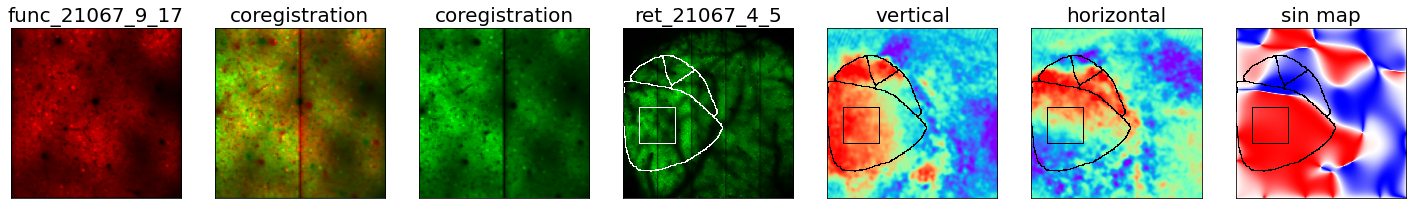

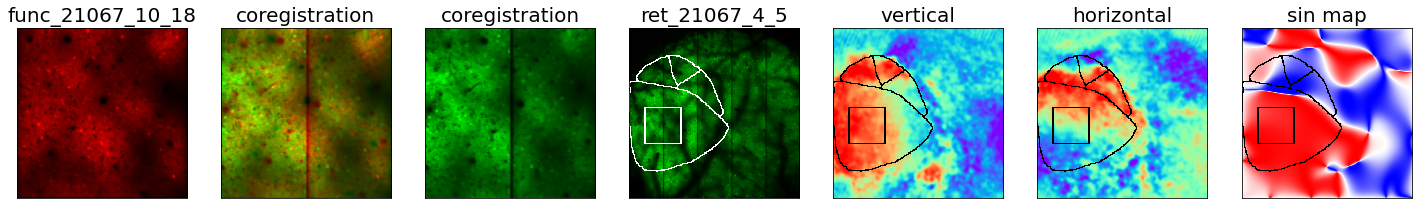

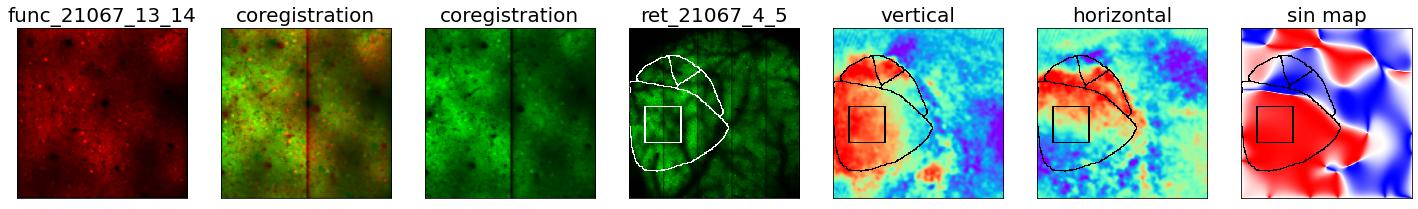

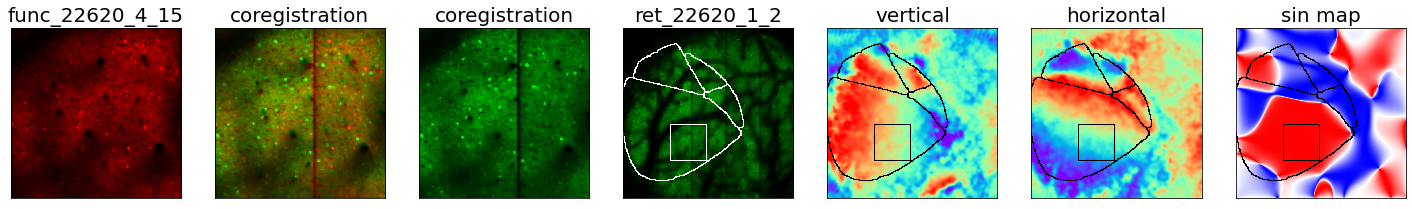

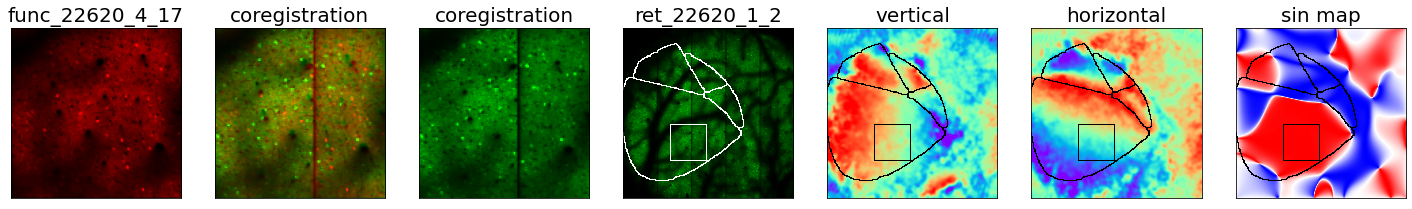

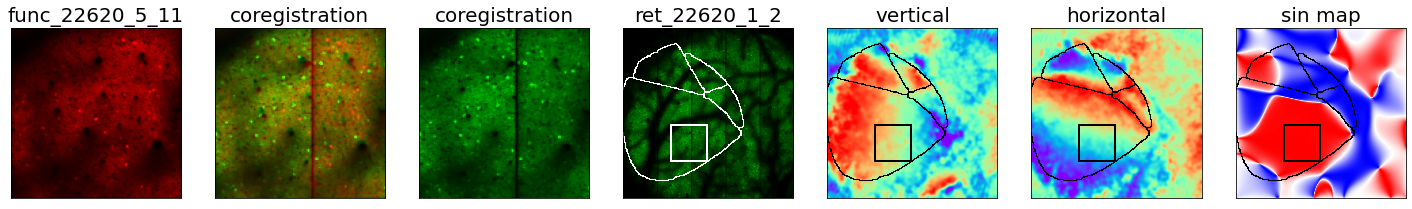

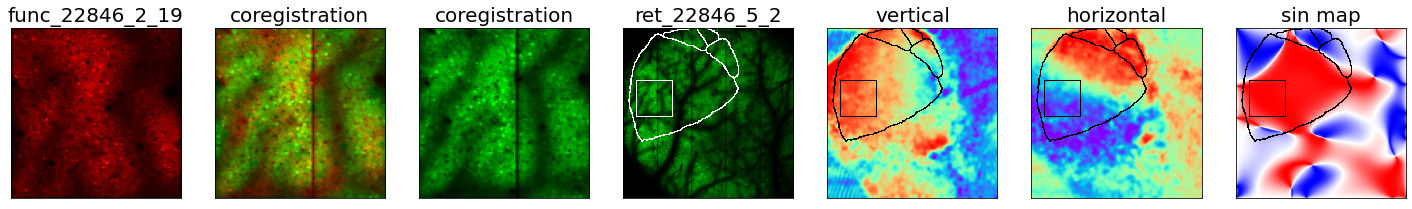

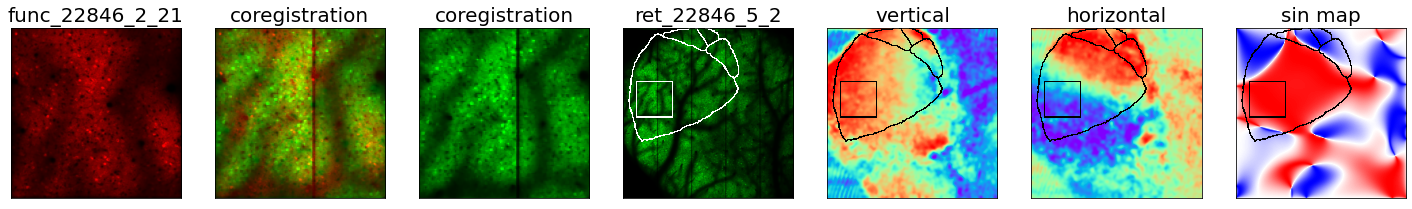

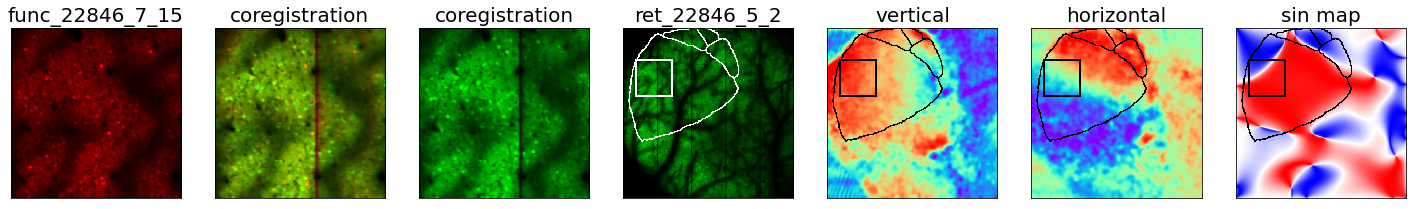

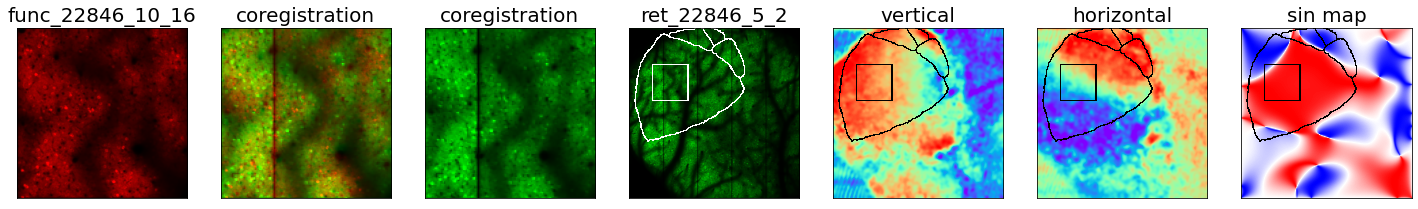

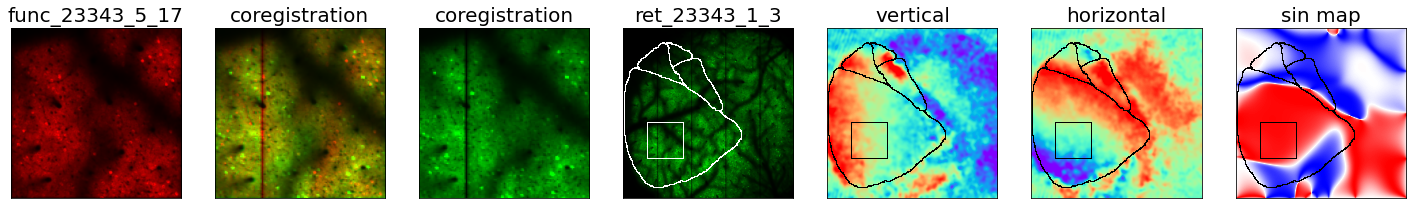

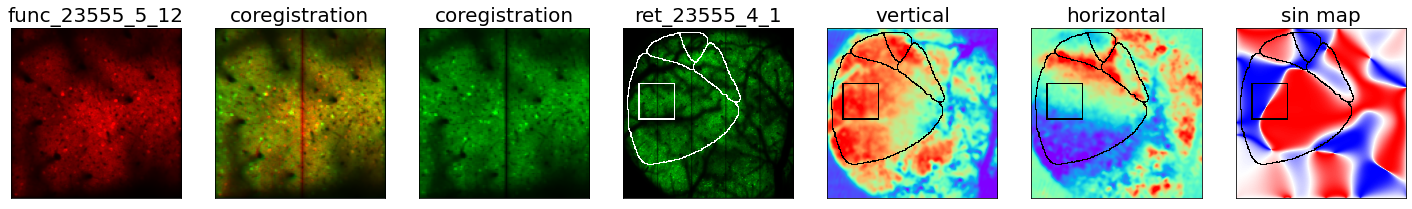

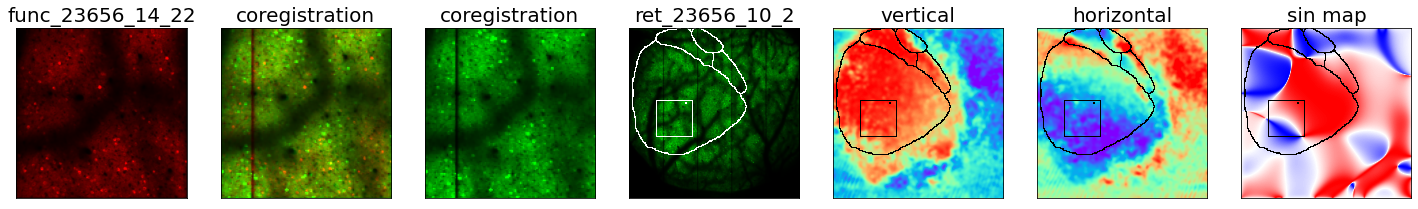

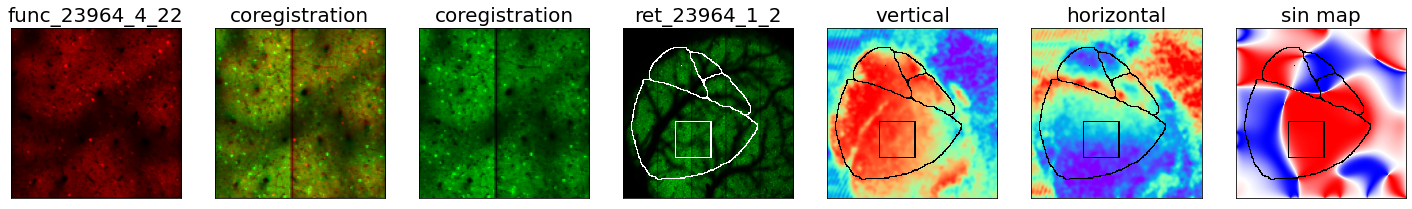

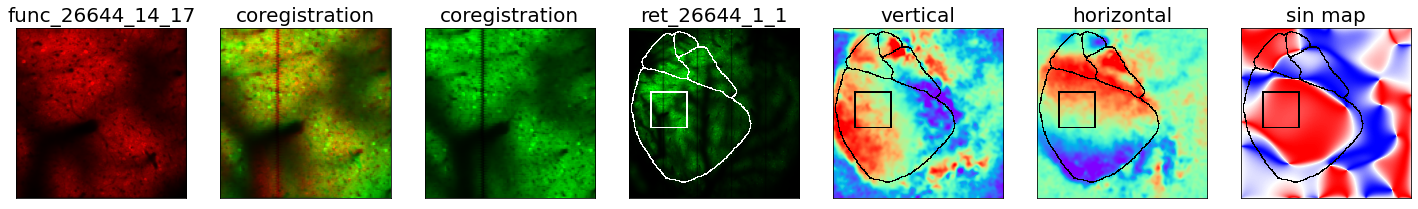

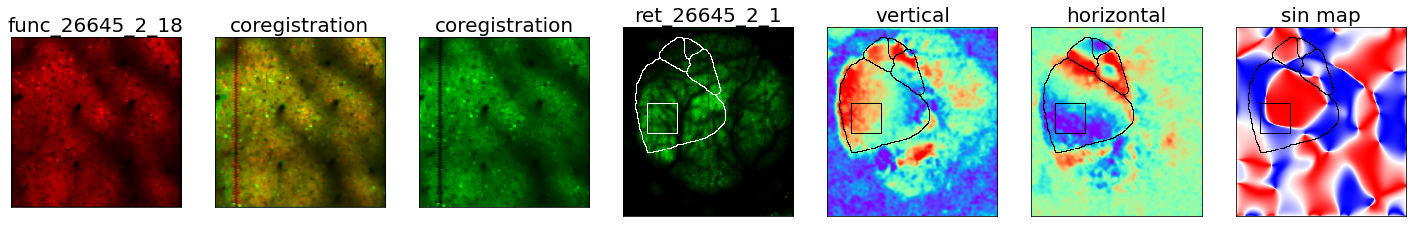

In [68]:
for scan_key in list(nda.Scan()):
    fig,axes = plt.subplots(1,7,figsize=(25,10))
    ret_key = (mask_keys & f'animal_id = {scan_key["animal_id"]}').fetch1('KEY')
    
# #     if a masked ret scan exists, prioritize masked and lowest session. Otherwise, prioritize lowest session
#     ret_key = (ret_keys & f'animal_id = {scan_key["animal_id"]}')
#     mask_key = mask_keys.proj() & ret_key
# #     if mask_key:
# #         mask_key = mask_key.fetch('KEY',order_by='session ASC',limit=1)[0]
# #         ret_key = mask_key
# #     else:
#     ret_key = ret_key.fetch('KEY',order_by='session ASC',limit=1)[0]
        
    ret_z_rel = dj.U('animal_id').aggr(meso.ScanInfo.Field & ret_key,mean_ret_z = 'AVG(z)')
    scan_field_key = (((meso.ScanInfo.Field & scan_key) * 
                   ret_z_rel).proj(z_diff = 'ABS(z-mean_ret_z)')).fetch('KEY',order_by='z_diff ASC',limit=1)[0]

    # fetch and plot the functional scan average image
    f_av_im = (meso.SummaryImages.Average & scan_field_key).fetch1('average_image').copy()
    f_av_im -= np.nanpercentile(f_av_im,0.1)
    f_av_im /= np.nanpercentile(f_av_im,99.9)
    f_av_im = np.clip(f_av_im,0,1)

    av_im = np.hstack((meso.SummaryImages.Average *
                      (meso.ScanInfo.Field & ret_key)).fetch('average_image',order_by='x ASC'))
    av_im -= np.nanpercentile(av_im,0.1)
    av_im /= np.nanpercentile(av_im,99.9)
    av_im = np.clip(av_im,0,1)
    
    hh,hw = (np.array(np.shape(f_av_im))/2).astype(int)

    r_pxh,r_pxw,r_umh,r_umw = (dj.U('px_height','px_width','um_height','um_width') & 
                               (meso.ScanInfo.Field & ret_key)).fetch1().values()
    f_pxh,f_pxw,f_umh,f_umw = (dj.U('px_height','px_width','um_height','um_width') & 
                               (meso.ScanInfo.Field & scan_field_key)).fetch1().values()

    r_res = list(set((r_pxh/r_umh,r_pxw/r_umw)))
    f_res = list(set((f_pxh/f_umh,f_pxw/f_umw)))
    assert len(r_res) == len(f_res) == 1

    pxpitch = f_res[0]/r_res[0]

    resized_av_im = cv2.resize(av_im,tuple((np.array(np.shape(av_im))*pxpitch).astype(int)[::-1]),
                               interpolation = cv2.INTER_AREA)
    resized_av_im = np.clip(resized_av_im,0,1)
    
    align_mat = feature.match_template(resized_av_im,f_av_im,pad_input=True)
    align_mask = np.zeros_like(align_mat)
    align_mask[hh:-hh,hw:-hw] = 1
    align_mat = align_mat * align_mask
    cy,cx = np.unravel_index(np.argmax(align_mat),np.array(np.shape(resized_av_im)).astype(int))

    rgba_im = np.zeros((*np.shape(f_av_im),4))
    rgba_im[:,:,0] = f_av_im
    rgba_im[:,:,-1] = 1
    
    axes[0].imshow(rgba_im)
    axes[0].set_title('func_'+'_'.join([str(s) for s in list(scan_key.values())[:3]]),fontsize=20)
    
    rgba_im[:,:,1] = np.pad(resized_av_im[np.max((cy-hh,0)):np.min((cy+hh,np.shape(resized_av_im)[0])),
                                          np.max((cx-hw,0)):np.min((cx+hw,np.shape(resized_av_im)[1]))],
                            ((-np.min((cy-hh,0)),-np.min((np.shape(resized_av_im)[0]-(cy+hh),0))),
                             (-np.min((cx-hw,0)),-np.min((np.shape(resized_av_im)[1]-(cx+hw),0)))))
    
    axes[1].imshow(rgba_im)
    axes[1].set_title('coregistration',fontsize=20)
    
    rgba_im = np.zeros((*np.shape(f_av_im),4))
    rgba_im[:,:,1] = np.pad(resized_av_im[np.max((cy-hh,0)):np.min((cy+hh,np.shape(resized_av_im)[0])),
                                          np.max((cx-hw,0)):np.min((cx+hw,np.shape(resized_av_im)[1]))],
                            ((-np.min((cy-hh,0)),-np.min((np.shape(resized_av_im)[0]-(cy+hh),0))),
                             (-np.min((cx-hw,0)),-np.min((np.shape(resized_av_im)[1]-(cx+hw),0)))))
    
    rgba_im[:,:,-1] = 1

    axes[2].imshow(rgba_im)
    axes[2].set_title('coregistration',fontsize=20)
    
    roi_mask = np.zeros_like(resized_av_im)
    roi_mask[np.max((cy-hh,0)):np.min((cy+hh,np.shape(resized_av_im)[0])),
             np.max((cx-hw,0)):np.min((cx+hw,np.shape(resized_av_im)[1]))] = 1
    roi_mask = cv2.resize(roi_mask,np.shape(av_im)[::-1])
    roi_mask = cv2.morphologyEx(roi_mask.astype(np.float32),cv2.MORPH_GRADIENT,np.ones((5,5)))
    roi_mask[roi_mask==0] = np.nan
    roi_mask[roi_mask>0] = 1
    
    # fetch and plot the retinotopic scan average image
    rgba_im = np.zeros((*np.shape(av_im),4))
    rgba_im[:,:,1] = av_im
    rgba_im[:,:,-1]=1
    
    axes[3].imshow(rgba_im)
    axes[3].set_title('ret_'+'_'.join([str(s) for s in list(ret_key.values())[1:4]]),fontsize=20)

    if maps.OptImageBar & ret_key:
        # fetch current angle of fancybar presentation maximizing intensity per pixel, for hor/vert presentations
        oris,angs = (maps.OptImageBar & ret_key).fetch('axis','ang')
        for ax,ori,ang in zip(axes[4:6],oris,angs):
            ang = ang % (2*np.pi)
            ang = gaussian_filter(ang,sigma=5)
            ang -= np.nanpercentile(ang,1)
            ang /= np.nanpercentile(ang,99)
            ax.imshow(ang,cmap='rainbow',vmin=0,vmax=1)
            ax.set_title(ori,fontsize=20)
        mod_angs = []
        for ang in angs:
            ang = ang % (2*np.pi)
            ang = gaussian_filter(ang,sigma=50)
            ang -= np.nanpercentile(ang,1)
            ang /= np.nanpercentile(ang,99)
            mod_angs.append(ang)
        grad_ang_diff = -np.diff([np.angle(np.gradient(a)[0] + np.gradient(a)[1]*1j) 
                                  for a in mod_angs],axis=0).squeeze()
        sin_map = np.sin(grad_ang_diff)
        map_max = np.max(np.abs(sin_map))

        axes[6].imshow(sin_map,cmap='bwr',vmin=-map_max,vmax=map_max)
        axes[6].set_title('sin map',fontsize=20)
        
#     if mask_key:
    ret_idx_key = dj.U(*anat.AreaMask.heading.primary_key[:-2]).aggr(
                            (anat.AreaMask & ret_key).proj('ret_idx'),ret_idx='MAX(ret_idx)')
    ret_idx_key = dj.U(*list(ret_idx_key.heading)) & ret_idx_key
    
    field_atts = ['x','px_width','um_width']
    nan_im = np.full_like(angs[0],np.nan)
    area_masks,bas,xs,pws,uws = ((anat.AreaMask & ret_idx_key & 'brain_area != "unknown"') * 
                                 meso.ScanInfo.Field).fetch('mask','brain_area',*field_atts)
    xs = xs * pws / uws # convert x to pixels
    xs -= np.min(xs - pws/2) # translate so leftmost boundary is pixel 0
    xs = np.round(xs).astype(int)
#     ret_key = (ret_keys & f'animal_id = {scan_key["animal_id"]}')
#     mask_key = mask_keys.proj() & ret_key
#     if mask_key:
#         mask_key = mask_key.fetch('KEY',order_by='session ASC',limit=1)[0]
#         ret_key = mask_key
#     else:
#     ret_key = ret_key.fetch('KEY',order_by='session ASC',limit=1)[0]
    
    hws = np.round(pws/2).astype(int)
    mask_outlines = np.full((len(area_masks),*np.shape(angs[0])),0)
    for mask_outline,area_mask,x,hw in zip(mask_outlines,area_masks,xs,hws):
        mask_outline[:,x-hw:x+hw] = area_mask
    area_outlines = []
    for brain_area in set(bas):
        if np.sum(bas==brain_area)>1:
            area_outlines.append(np.max(mask_outlines[bas==brain_area,:,:],axis=0))
        else:
            area_outlines.append(mask_outlines[bas==brain_area].squeeze())
    area_outlines = [cv2.morphologyEx(area_outline.astype(np.float32), cv2.MORPH_GRADIENT, np.ones((5, 5))) 
                     for area_outline in area_outlines]
    area_outline = np.max(area_outlines,axis=0)
#     area_outline = cv2.morphologyEx(area_outline, cv2.MORPH_CLOSE, np.ones((10, 10)))
    area_outline[area_outline == 0] = np.nan

    axes[3].imshow(area_outline,cmap='binary',interpolation='nearest')

    for ax in axes[4:7]:
        ax.imshow(area_outline,cmap='binary_r',interpolation='nearest')
    
    axes[3].imshow(roi_mask,cmap='binary',interpolation='nearest')
    for ax in axes[4:7]:
        ax.imshow(roi_mask,cmap='binary_r',interpolation='nearest')

    for ax in axes.ravel():
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
    plt.show()
    plt.close()
